# Entanglement Boosting: Step-by-Step Complete Understanding Guide

This notebook walks through the entire repository step by step.

## Notebook Structure

1. **Setup and Imports** - Checking required libraries
2. **Stim Basics** - Fundamentals of quantum circuit simulation library
3. **Utility Layer Deep Dive** - QubitMapping, Circuit, NoiseConfiguration
4. **Surface Code Understanding** - How syndrome measurements work
5. **Entanglement Boosting Protocol** - Details of the main algorithm
6. **Simulation and Result Analysis** - How to interpret results
7. **Advanced Examples** - With noise and post-selection enabled

## 0. Setup and Imports


In [12]:
import sys
from pathlib import Path

import stim
import pymatching

# --- Make local imports work regardless of notebook cwd ---
# We want to import from `src/` (which contains `entanglement_boosting.py`, `util.py`, etc.).
# Depending on how Jupyter is launched, the current working directory may be the repo root
# or the `notebooks/` directory.
repo_root = Path.cwd()
if not (repo_root / 'src').exists():
    # If we're in `notebooks/`, go one level up.
    if (repo_root.parent / 'src').exists():
        repo_root = repo_root.parent

src_path = str(repo_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import entanglement_boosting as eb
import util
import surface_code

print('cwd:', Path.cwd())
print('src_path:', src_path)
print('stim', stim.__version__)
print('pymatching', pymatching.__version__)

cwd: /Users/seigokikura/code/entanglement-boosting/notebooks
src_path: /Users/seigokikura/code/entanglement-boosting/src
stim 1.15.0
pymatching 2.3.1


## 1. Repository Map and Key Classes

This walkthrough focuses on these files:

- `src/util.py`: qubit coordinate mapping, circuit wrapper, and noise configuration.
- `src/surface_code.py`: stabilizer measurement patterns and helper classes.
- `src/entanglement_boosting.py`: distillation circuit builder and simulation helpers.
- `notebooks/entanglement_boosting_walkthrough.ipynb`: this step-by-step notebook.

We'll go from Stim basics → mapping/circuit wrapper → surface code patch → entanglement boosting → analysis.


## 2. Stim Basics: Building a Tiny Circuit


In [13]:
c = stim.Circuit()
c.append('H', 0)
c.append('M', 0)
print(c)

H 0
M 0


## 3. Stim Basics: Sampling


In [14]:
sampler = c.compile_sampler()
samples = sampler.sample(shots=10)
samples

array([[False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False]])

## 4. Stim built-in visualization (diagram)


## 5. Utility Layer: Deep Dive into Circuit Wrapper


Mapping size: width=3, height=3
Total number of qubits: 5
First 5 qubits: [(0, (0, 0)), (1, (0, 2)), (2, (2, 0)), (3, (2, 2)), (4, (1, 1))]

Qubit ID at coordinate (0,0): 0
Qubit ID at coordinate (1,1): 4

=== Circuit Construction ===

Generated circuit:
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(0, 2) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(2, 2) 3
QUBIT_COORDS(1, 1) 4
RX 0
R 2
TICK
CX 0 4
TICK
M 2
TICK


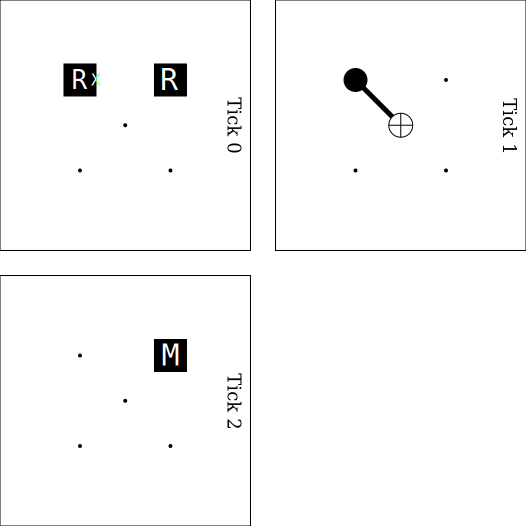

In [15]:
# Create a small mapping and a noiseless circuit
mapping = util.QubitMapping(width=3, height=3)
print(f"Mapping size: width={mapping.width}, height={mapping.height}")
print(f"Total number of qubits: {len(mapping.mapping)}")
print(f"First 5 qubits: {mapping.mapping[:5]}")

# Example of getting ID from coordinates
print(f"\nQubit ID at coordinate (0,0): {mapping.get_id(0, 0)}")
print(f"Qubit ID at coordinate (1,1): {mapping.get_id(1, 1)}")

# Create circuit with noiseless configuration
noise = util.NO_ERROR_CONF
cwrap = util.Circuit(mapping, noise)

# Place a few operations using the wrapper
# IMPORTANT: `util.Circuit` enforces "one gate per tick per qubit".
# That means if a qubit is used by an operation, you must insert `place_tick()`
# before using that qubit again.
print("\n=== Circuit Construction ===")

# Tick 0: resets
cwrap.place_reset_x((0, 0))  # Reset in X basis
cwrap.place_reset_z((2, 0))  # Reset in Z basis
cwrap.place_tick()

# Tick 1: CX
cwrap.place_cx((0, 0), (1, 1))  # Controlled-NOT gate (nearest-neighbor only)
cwrap.place_tick()

# Tick 2: measurement
cwrap.place_measurement_z((2, 0))  # Measure in Z basis
cwrap.place_tick()  # Final tick

print("\nGenerated circuit:")
print(cwrap.circuit)
cwrap.circuit.diagram("timeslice-svg")

## 6. Surface Code Patch Layout


Total number of syndrome measurements: 8

First 5 syndrome measurement positions:
  1. Position (2, 0): SurfaceXSyndromeMeasurement
  2. Position (2, 2): SurfaceZSyndromeMeasurement
  3. Position (4, 2): SurfaceXSyndromeMeasurement
  4. Position (6, 2): SurfaceZSyndromeMeasurement
  5. Position (0, 4): SurfaceZSyndromeMeasurement

Logical X Pauli string: +________________XXX
Logical Z Pauli string: +________________Z__Z__Z


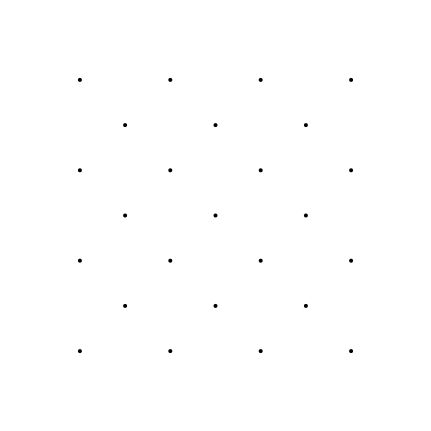

In [16]:
# Create a surface code patch
# Set distance/offset first so mapping is large enough for data + ancilla qubits.
distance = 3
offset = (1, 1)

# Data qubits live on even-even (or odd-odd) coordinates; ancillas are offset by +1.
max_data_x = offset[0] + (distance - 1) * 2
max_data_y = offset[1] + (distance - 1) * 2
max_ancilla_x = max_data_x + 1
max_ancilla_y = max_data_y + 1
mapping = util.QubitMapping(width=max_ancilla_x + 1, height=max_ancilla_y + 1)

cwrap = util.Circuit(mapping, util.NO_ERROR_CONF)

# SurfaceCodePatch parameters:
# - offset: Starting position of the patch
# - bell_distance: Distance of Bell pair (d_Bell)
# - distance: Surface code distance (d_s)
patch = eb.SurfaceCodePatch(cwrap, offset=offset, bell_distance=2, distance=distance)

print(f"Total number of syndrome measurements: {len(patch.syndrome_measurements)}")
print(f"\nFirst 5 syndrome measurement positions:")
for i, (pos, measurement) in enumerate(list(patch.syndrome_measurements.items())[:5]):
    print(f"  {i+1}. Position {pos}: {type(measurement).__name__}")

# Check logical X and Z Pauli strings
print(f"\nLogical X Pauli string: {patch.logical_x_pauli_string()}")
print(f"Logical Z Pauli string: {patch.logical_z_pauli_string()}")

patch.circuit.circuit.diagram("timeslice-svg")

## 7. Building the Entanglement Boosting Circuit (Small Size)


=== Building Entanglement Boosting Circuit ===
bell_distance (d_Bell) = 2
surface_distance (d_s) = 3
Bell error probability = 0.0
Post-selection = False

Generated circuit (first 500 lines):
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(0, 2) 1
QUBIT_COORDS(0, 4) 2
QUBIT_COORDS(0, 6) 3
QUBIT_COORDS(2, 0) 4
QUBIT_COORDS(2, 2) 5
QUBIT_COORDS(2, 4) 6
QUBIT_COORDS(2, 6) 7
QUBIT_COORDS(4, 0) 8
QUBIT_COORDS(4, 2) 9
QUBIT_COORDS(4, 4) 10
QUBIT_COORDS(4, 6) 11
QUBIT_COORDS(6, 0) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(6, 4) 14
QUBIT_COORDS(6, 6) 15
QUBIT_COORDS(8, 0) 16
QUBIT_COORDS(8, 2) 17
QUBIT_COORDS(8, 4) 18
QUBIT_COORDS(8, 6) 19
QUBIT_COORDS(10, 0) 20
QUBIT_COORDS(10, 2) 21
QUBIT_COORDS(10, 4) 22
QUBIT_COORDS(10, 6) 23
QUBIT_COORDS(12, 0) 24
QUBIT_COORDS(12, 2) 25
QUBIT_COORDS(12, 4) 26
QUBIT_COORDS(12, 6) 27
QUBIT_COORDS(14, 0) 28
QUBIT_COORDS(14, 2) 29
QUBIT_COORDS(14, 4) 30
QUBIT_COORDS(14, 6) 31
QUBIT_COORDS(1, 1) 32
QUBIT_COORDS(1, 3) 33
QUBIT_COORDS(1, 5) 34
QUBIT_COORDS(3, 1) 35
QUBIT_COORDS(3,

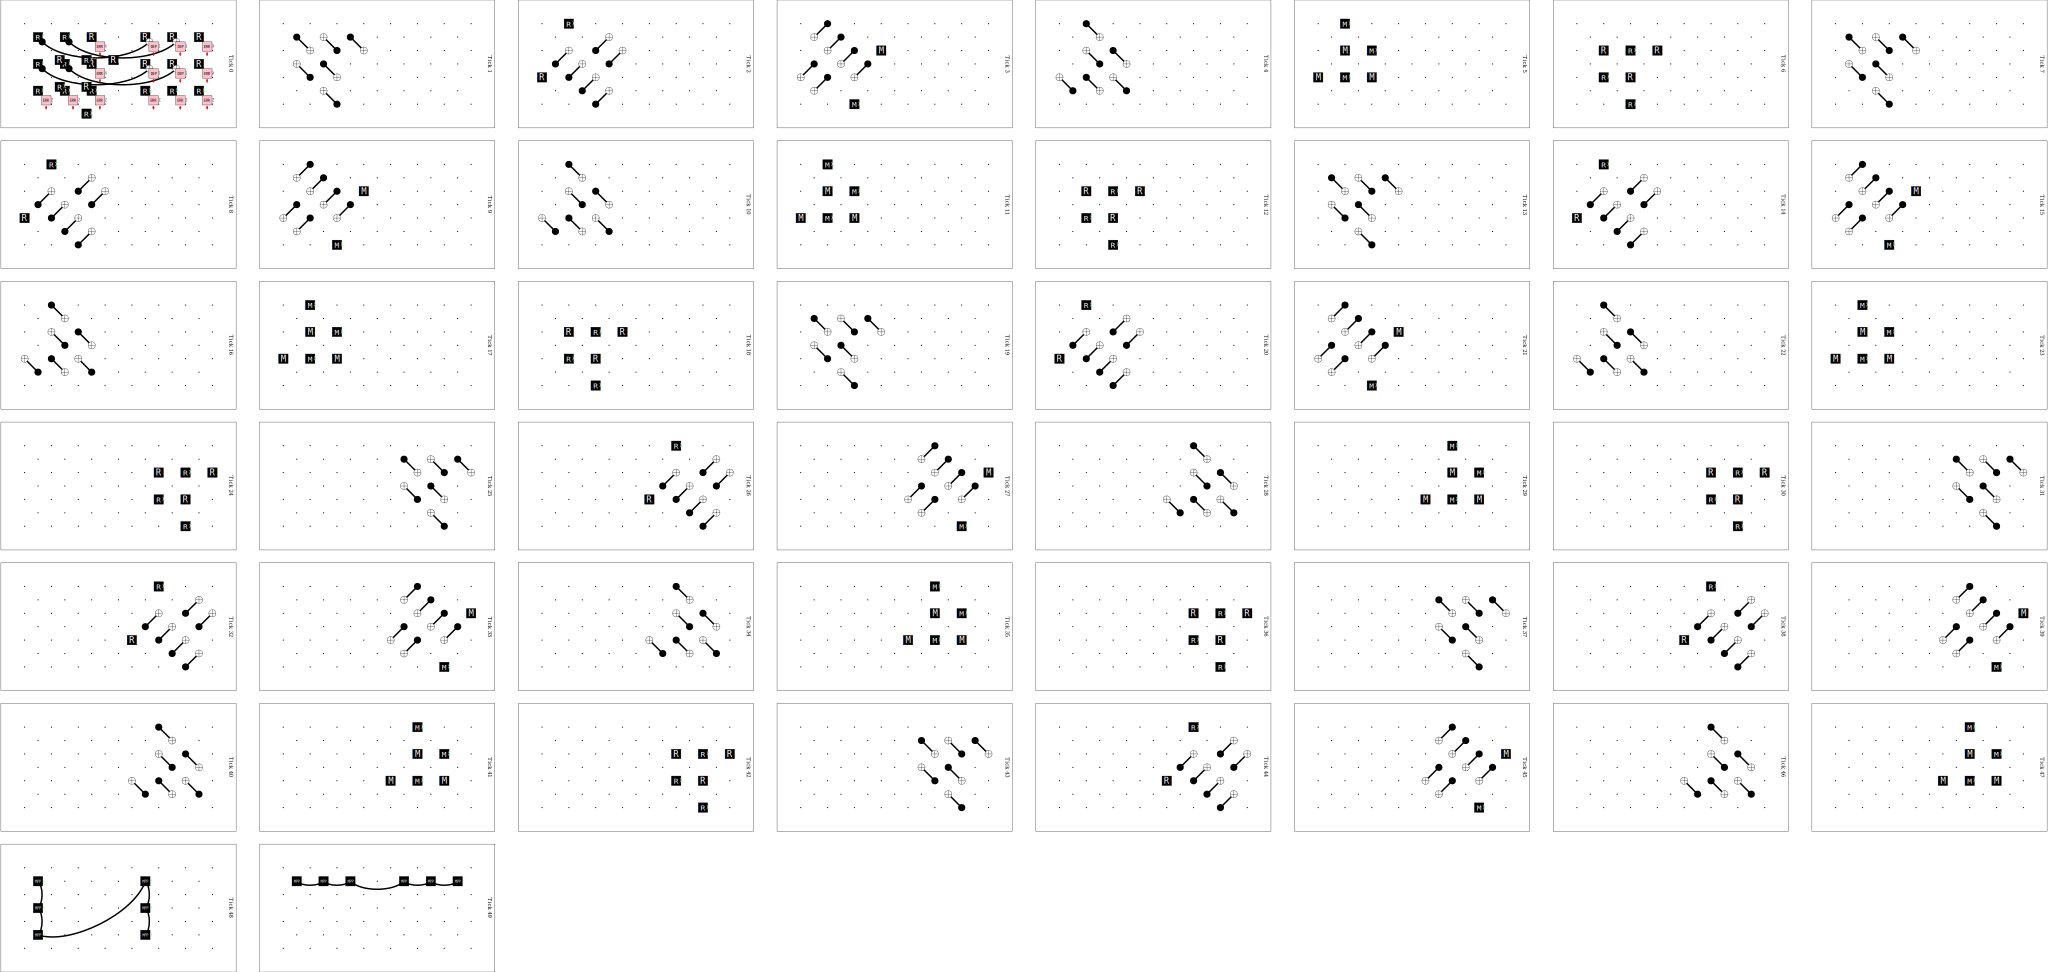

In [17]:
# Noiseless configuration (for easier understanding initially)
noise_conf = util.NoiseConfiguration(
    single_qubit_gate_error_probability=0.0,
    two_qubit_gate_error_probability=0.0,
    reset_error_probability=0.0,
    measurement_error_probability=0.0,
    idle_error_probability=0.0,
)

print("=== Building Entanglement Boosting Circuit ===")
print(f"bell_distance (d_Bell) = 2")
print(f"surface_distance (d_s) = 3")
print(f"Bell error probability = 0.0")
print(f"Post-selection = False\n")

circuits = eb.perform_distillation(
    bell_distance=2,
    surface_distance=3,
    noise_conf=noise_conf,
    bell_error_probability=0.0,
    post_selection=False,
)

print("Generated circuit (first 500 lines):")
circuit_str = str(circuits.circuit.circuit)
lines = circuit_str.split('\n')
for line in lines[:500]:
    print(line)
if len(lines) > 500:
    print(f"\n... (remaining {len(lines) - 500} lines)")

print(f"\nCircuit statistics:")
print(f"  Number of qubits: {circuits.circuit.circuit.num_qubits}")
print(f"  Number of measurements: {circuits.circuit.circuit.num_measurements}")
print(f"  Number of detectors: {circuits.circuit.circuit.num_detectors}")
print(f"  Number of observables: {circuits.circuit.circuit.num_observables}")

circuits.circuit.circuit.diagram("timeslice-svg")

## 7.5 CLI Example (Scaled Down) — Step-by-Step

The README example runs a large simulation. Here we reproduce the same **flow** with a smaller
configuration so it is easy to visualize and understand in the notebook.

- Same pipeline: build circuit → run syndrome rounds → logical MPPs → detectors/observables → sample shots
- Smaller parameters to keep the circuit and diagrams readable


In [18]:
# Scaled-down version of the CLI example
small_surface_distance = 3
small_bell_distance = 2
small_num_shots = 50
small_error_probability = 0.001
small_bell_error_probability = 0.01

small_noise_conf = util.NoiseConfiguration(
    single_qubit_gate_error_probability=small_error_probability,
    two_qubit_gate_error_probability=small_error_probability,
    reset_error_probability=small_error_probability,
    measurement_error_probability=small_error_probability,
    idle_error_probability=small_error_probability,
)

print('=== Scaled-down CLI parameters ===')
print(f'd_s (surface_distance) = {small_surface_distance}')
print(f'd_Bell (bell_distance) = {small_bell_distance}')
print(f'num_shots = {small_num_shots}')
print(f'error_probability = {small_error_probability}')
print(f'bell_error_probability = {small_bell_error_probability}')

small_circuits = eb.perform_distillation(
    bell_distance=small_bell_distance,
    surface_distance=small_surface_distance,
    noise_conf=small_noise_conf,
    bell_error_probability=small_bell_error_probability,
    post_selection=False,
)

print('Circuit size:')
print('  qubits      =', small_circuits.circuit.circuit.num_qubits)
print('  measurements=', small_circuits.circuit.circuit.num_measurements)
print('  detectors   =', small_circuits.circuit.circuit.num_detectors)
print('  observables =', small_circuits.circuit.circuit.num_observables)


=== Scaled-down CLI parameters ===
d_s (surface_distance) = 3
d_Bell (bell_distance) = 2
num_shots = 50
error_probability = 0.001
bell_error_probability = 0.01
Circuit size:
  qubits      = 53
  measurements= 66
  detectors   = 59
  observables = 2


### Step 1 — Patch geometry and ancilla placement
We recreate the patch geometry to visualize where data and ancilla qubits live.


In [19]:
# Reconstruct the patch placement (matching entanglement_boosting.py)
sd = small_surface_distance
bd = small_bell_distance
offset1 = (1, 1)
offset2 = (1 + sd * 2 + 2, 1)
(offset1_x, offset1_y) = offset1
(offset2_x, offset2_y) = offset2

mapping = util.QubitMapping(1 + sd * 2 * 2 + 2, 1 + sd * 2)
geo_circuit = util.Circuit(mapping, util.NO_ERROR_CONF)

patch1 = eb.SurfaceCodePatch(geo_circuit, offset1, bd, sd)
patch2 = eb.SurfaceCodePatch(geo_circuit, offset2, bd, sd)

print('patch1 offset:', offset1, 'patch2 offset:', offset2)
print('patch1 syndrome measurements:', len(patch1.syndrome_measurements))
print('patch2 syndrome measurements:', len(patch2.syndrome_measurements))

# Visualize a small grid for patch1 (D=data, A=ancilla)
max_x = offset1_x + (sd - 1) * 2 + 1
max_y = offset1_y + (sd - 1) * 2 + 1
data = {(offset1_x + j*2, offset1_y + i*2) for i in range(sd) for j in range(sd)}
anc = set(patch1.syndrome_measurements.keys())

lines = []
for y in range(max_y, offset1_y - 2, -1):
    row = []
    for x in range(offset1_x - 2, max_x + 1):
        if (x, y) in data:
            row.append('D')
        elif (x, y) in anc:
            row.append('A')
        else:
            row.append('.')
    lines.append(' '.join(row))

print('Patch1 grid (top to bottom):')
for line in lines:
    print(line)


patch1 offset: (1, 1) patch2 offset: (9, 1)
patch1 syndrome measurements: 8
patch2 syndrome measurements: 8
Patch1 grid (top to bottom):
. . . . . A . .
. . D . D . D .
. A . A . A . .
. . D . D . D .
. . . A . A . A
. . D . D . D .
. . . A . . . .


### Step 2 — Visualize the circuit structure (small)
We render a small SVG timeslice view so you can see the sequence of operations.


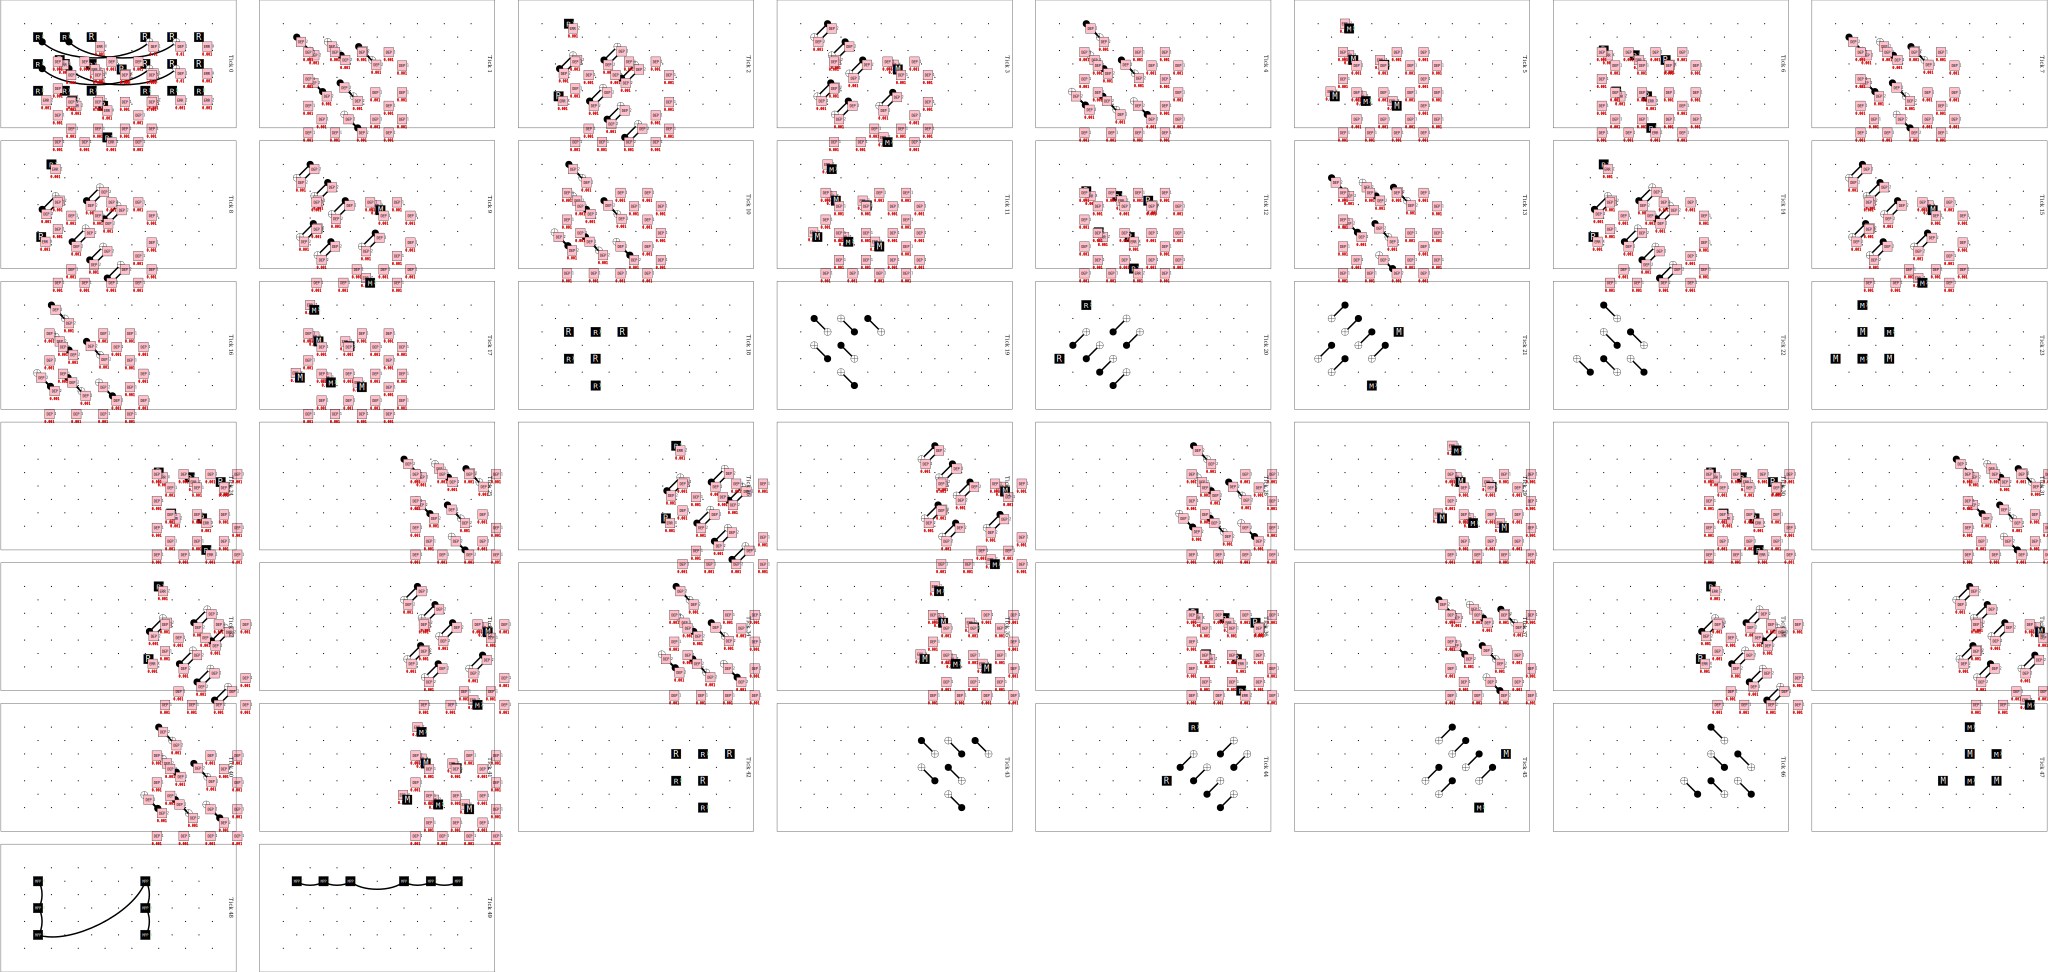

In [20]:
# Timeslice visualization (small circuit)
small_circuits.circuit.circuit.diagram('timeslice-svg')


### Step 3 — Sample a few shots (no DEM)
The full CLI pipeline constructs a DEM for decoding. Here we sample detector outcomes
and observables directly to inspect the raw behavior at small size.


In [21]:
stim_circuit = small_circuits.circuit.circuit
sampler = stim_circuit.compile_detector_sampler(seed=0)
dets, obs = sampler.sample(small_num_shots, separate_observables=True)

print('shots:', small_num_shots)
print('detection_events shape:', dets.shape)
print('observable_flips shape:', obs.shape)
print('detector fires per shot (first 10):', dets.sum(axis=1)[:10])
print('observable flips (first 10):', obs[:10])


shots: 50
detection_events shape: (50, 59)
observable_flips shape: (50, 2)
detector fires per shot (first 10): [4 4 3 2 0 3 2 5 6 1]
observable flips (first 10): [[False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [ True False]
 [False  True]
 [False False]]


### Step 4 — Decode with a DEM (drop non-deterministic detectors)
The CLI uses a **detector error model (DEM)** to build a matching graph, then decodes each
shot to predict logical observables. In this notebook, the circuit contains **non-deterministic
detectors** (the logical MPP measurements), which prevents DEM construction.

To still demonstrate decoding, we build a **filtered circuit** that **removes only the tagged
logical detectors** and their OBSERVABLE_INCLUDE lines. The stabilizer detectors remain, so
we can form a DEM and decode.


In [22]:
# Build a filtered circuit for decoding (remove logical DETECTORs by tag)
import re
def filter_out_tagged_detectors(stim_circuit, tags_to_drop):
    text = str(stim_circuit)
    out_lines = []
    for line in text.split('\n'):
        if line.startswith('DETECTOR'):
            if any(f'tag={tag}' in line for tag in tags_to_drop):
                continue
        # We also drop OBSERVABLE_INCLUDE tied to removed logical detectors (they share the tag)
        if line.startswith('OBSERVABLE_INCLUDE'):
            if any(f'tag={tag}' in line for tag in tags_to_drop):
                continue
        out_lines.append(line)
    return stim.Circuit('\n'.join(out_lines))

def drop_detector_by_id(stim_circuit, drop_ids):
    text = str(stim_circuit)
    out_lines = []
    det_id = 0
    for line in text.split('\n'):
        if line.startswith('DETECTOR'):
            if det_id in drop_ids:
                det_id += 1
                continue
            det_id += 1
        out_lines.append(line)
    return stim.Circuit('\n'.join(out_lines))

def build_deterministic_dem(stim_circuit, max_drops=20):
    dropped = []
    working = stim_circuit
    for _ in range(max_drops):
        try:
            dem = working.detector_error_model(decompose_errors=True)
            return working, dem, dropped
        except ValueError as e:
            msg = str(e)
            # Look for detector IDs in the error message, e.g. 'D32'
            m = re.search(r'D(\d+)', msg)
            if not m:
                raise
            bad_id = int(m.group(1))
            dropped.append(bad_id)
            working = drop_detector_by_id(working, {bad_id})
    raise ValueError(f'Exceeded max_drops={max_drops} while trying to build DEM')

tags_to_drop = ['X_COMPLEMENTARY_GAP', 'Z_COMPLEMENTARY_GAP']
filtered = filter_out_tagged_detectors(small_circuits.circuit.circuit, tags_to_drop)

print('Original detectors:', small_circuits.circuit.circuit.num_detectors)
print('Filtered detectors:', filtered.num_detectors)

# Try to build a deterministic DEM by dropping any remaining non-deterministic detectors
filtered, dem, dropped = build_deterministic_dem(filtered, max_drops=30)
print('DEM constructed:', dem is not None)
print('Dropped non-deterministic detector IDs:', dropped)


Original detectors: 59
Filtered detectors: 59
DEM constructed: True
Dropped non-deterministic detector IDs: [32, 31, 30]


### What decoding does (intuition)
- The DEM turns the circuit into a **graph of detector correlations** (edges with error probabilities).
- `pymatching` builds a **minimum‑weight perfect matching** decoder on that graph.
- Each shot gives a binary detector vector (the **syndrome**). The decoder picks the **most likely
  error configuration** consistent with that syndrome, then predicts logical flips.


In [23]:
# Decode a few shots with pymatching
matcher = pymatching.Matching.from_detector_error_model(dem.without_tags())

sampler = filtered.compile_detector_sampler(seed=0)
dets, obs = sampler.sample(small_num_shots, separate_observables=True)

num_shots = small_num_shots
for i in range(min(num_shots, 5)):
    syndrome = dets[i]
    prediction = matcher.decode(syndrome)
    print(f'shot {i}: decoded obs = {prediction}')

print('Decoded', num_shots, 'shots.')

# Note: We may have dropped some non-deterministic detectors to build the DEM.
# This is for understanding the decoding pipeline, not for faithful scientific results.
print('Dropped detector IDs during DEM build:', dropped)


shot 0: decoded obs = [0 0]
shot 1: decoded obs = [0 0]
shot 2: decoded obs = [0 0]
shot 3: decoded obs = [0 0]
shot 4: decoded obs = [0 0]
Decoded 50 shots.
Dropped detector IDs during DEM build: [32, 31, 30]


## 8. Simulating a Few Shots


In [8]:
# Run a small number of shots (Notebook-only helper; keep src untouched)
num_shots = 20
stim_circuit = circuits.circuit.circuit

# DEM construction can fail here because the circuit contains non-deterministic detectors
# (e.g., logical MPP measurements are not stabilizers). For understanding src,
# we still sample detector outcomes/observables without building the DEM.
try:
    _ = stim_circuit.detector_error_model(decompose_errors=True)
    print('DEM construction: OK')
except ValueError as e:
    print('DEM construction failed (expected in this notebook context).')
    print('Reason:', e)

sampler = stim_circuit.compile_detector_sampler(seed=0)
detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

print('=== Simulation Snapshot (no DEM) ===')
print(f'Total shots: {num_shots}')
print('detection_events shape:', detection_events.shape)
print('observable_flips shape:', observable_flips.shape)

# Simple diagnostics for intuition
fired_counts = detection_events.sum(axis=1)
print('detector fires per shot (first 10):', fired_counts[:10])
print('observable flips (first 10):', observable_flips[:10])


DEM construction failed (expected in this notebook context).
Reason: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D32', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D32 > output_image.svg

This was discovered while analyzing an X-basis reset (RX) on:
    qubit 52 [coords (13, 5)]

The collapse anti-commuted with these detectors/observables:
    D32

The backward-propagating error sensitivity for D32 was:
    Z37 [coords (3, 5)]
    Z39 [coords (5, 3)]
    Z40 [coords (5, 5)]
    Z48 [coords (11, 3)]
    Z49 [coords (11, 5)]
    Z51 [coords (13, 3)]
    Z52 [coords (13, 5)]

Circuit stack trace:
    during TICK layer #1 of 50
    at instruction #60 [which is RX 46 49 52]
=== Simulation Snapshot (no DEM) ===
Total shots: 20
detecti

## 8.1 Detailed Inspection of Complementary Gap Buckets


In [9]:
# Show non-empty buckets
non_empty = [(i, b) for i, b in enumerate(results.buckets) if len(b) > 0]
print(f"Number of non-empty buckets: {len(non_empty)}")
print("\nFirst 5 buckets:")
for gap, bucket in non_empty[:5]:
    success_rate = bucket.num_valid_samples / len(bucket) if len(bucket) > 0 else 0
    print(f"  Gap [{gap}, {gap+1}): "
          f"valid={bucket.num_valid_samples}, "
          f"wrong={bucket.num_wrong_samples}, "
          f"success_rate={success_rate:.2%}")

NameError: name 'results' is not defined

## 9. Add Noise and See What Changes

Now we add realistic noise to see how error rates change and how post-selection helps.


In [10]:
# Build circuit with noise configuration
noise_conf_with_errors = util.NoiseConfiguration(
    single_qubit_gate_error_probability=0.001,  # Single-qubit gate error probability
    two_qubit_gate_error_probability=0.001,     # Two-qubit gate error probability
    reset_error_probability=0.001,              # Reset error probability
    measurement_error_probability=0.001,        # Measurement error probability
    idle_error_probability=0.0001,              # Idle error probability
)

print("=== Building Circuit with Noise ===")
circuits_noisy = eb.perform_distillation(
    bell_distance=2,
    surface_distance=3,
    noise_conf=noise_conf_with_errors,
    bell_error_probability=0.01,  # Bell pair error probability (typically higher)
    post_selection=False,
)

# Simulate with more shots
print("\n=== Simulation with Noise ===")
results_noisy = eb.perform_simulation(circuits_noisy, num_shots=1000, seed=42)

print(f"Total shots: 1000")
print(f"Discarded samples: {results_noisy.num_discarded_samples}")
print(f"Valid samples: {len(results_noisy) - results_noisy.num_discarded_samples}")

# Calculate error rate
total_valid = sum(b.num_valid_samples for b in results_noisy.buckets)
total_wrong = sum(b.num_wrong_samples for b in results_noisy.buckets)
if total_valid + total_wrong > 0:
    error_rate = total_wrong / (total_valid + total_wrong)
    print(f"Error rate: {error_rate:.4f} ({error_rate*100:.2f}%)")

=== Building Circuit with Noise ===

=== Simulation with Noise ===


ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D32', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D32 > output_image.svg

This was discovered while analyzing an X-basis reset (RX) on:
    qubit 52 [coords (13, 5)]

The collapse anti-commuted with these detectors/observables:
    D32

The backward-propagating error sensitivity for D32 was:
    Z37 [coords (3, 5)]
    Z39 [coords (5, 3)]
    Z40 [coords (5, 5)]
    Z48 [coords (11, 3)]
    Z49 [coords (11, 5)]
    Z51 [coords (13, 3)]
    Z52 [coords (13, 5)]

Circuit stack trace:
    during TICK layer #1 of 50
    at instruction #60 [which is RX 46 49 52]

## 10. Simulation with Post-Selection


In [ ]:
# Build circuit with post-selection enabled
print("=== Building Circuit with Post-Selection ===")
circuits_postselect = eb.perform_distillation(
    bell_distance=2,
    surface_distance=3,
    noise_conf=noise_conf_with_errors,
    bell_error_probability=0.01,
    post_selection=True,  # Enable post-selection
)

# Run simulation
print("\n=== Simulation with Post-Selection ===")
results_postselect = eb.perform_simulation(circuits_postselect, num_shots=1000, seed=42)

print(f"Total shots: 1000")
print(f"Discarded samples: {results_postselect.num_discarded_samples}")
print(f"Valid samples: {len(results_postselect) - results_postselect.num_discarded_samples}")

# Calculate error rate
total_valid_ps = sum(b.num_valid_samples for b in results_postselect.buckets)
total_wrong_ps = sum(b.num_wrong_samples for b in results_postselect.buckets)
if total_valid_ps + total_wrong_ps > 0:
    error_rate_ps = total_wrong_ps / (total_valid_ps + total_wrong_ps)
    print(f"Error rate: {error_rate_ps:.4f} ({error_rate_ps*100:.2f}%)")
    print(f"\nComparison with error rate without post-selection:")
    if total_valid + total_wrong > 0:
        error_rate_no_ps = total_wrong / (total_valid + total_wrong)
        print(f"  Without post-selection: {error_rate_no_ps:.4f} ({error_rate_no_ps*100:.2f}%)")
        print(f"  With post-selection: {error_rate_ps:.4f} ({error_rate_ps*100:.2f}%)")
        improvement = (error_rate_no_ps - error_rate_ps) / error_rate_no_ps * 100 if error_rate_no_ps > 0 else 0
        print(f"  Improvement: {improvement:.1f}%")

## 11. Post-Selection Based on Complementary Gap


In [ ]:
# Calculate error rates at different discard rates
def analyze_discard_rates(results, num_shots):
    """Analyze error rates at different discard rates"""
    discard_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    num_unconditionally_discarded = results.num_discarded_samples
    num_total_samples = len(results)
    
    print(f"\n=== Analysis by Discard Rate ===")
    print(f"{'Discard Rate':<12} {'Gap Threshold':<15} {'Valid':<8} {'Wrong':<8} {'Discarded':<10} {'Error Rate':<12}")
    print("-" * 75)
    
    for discard_rate in discard_rates:
        num_valid = 0
        num_wrong = 0
        num_discarded = num_unconditionally_discarded
        discarding = True
        gap_threshold = results.max_gap()
        
        for (gap, bucket) in enumerate(results.buckets):
            if discarding and len(bucket) + num_discarded <= num_total_samples * discard_rate:
                num_discarded += len(bucket)
                continue
            
            if discarding:
                discarding = False
                gap_threshold = gap
            
            num_valid += bucket.num_valid_samples
            num_wrong += bucket.num_wrong_samples
        
        error_rate = num_wrong / (num_valid + num_wrong) if (num_valid + num_wrong) > 0 else float('nan')
        print(f"{discard_rate:<12.2f} {gap_threshold:<15} {num_valid:<8} {num_wrong:<8} {num_discarded:<10} {error_rate:<12.4f}")

# Analyze results with noise
analyze_discard_rates(results_noisy, 1000)

## 12. Parallel Simulation for Large-Scale Runs


In [ ]:
# Example of parallel simulation (using fewer shots for demonstration)
print("=== Parallel Simulation Example ===")
print("Note: For demonstration, we use a small number of shots.")
print("In practice, use larger num_shots (e.g., 10000+) to see benefits of parallelism.\n")

# Use the same circuit configuration as before
parallel_results = eb.perform_parallel_simulation(
    circuits_noisy,
    num_shots=2000,
    parallelism=2,  # Number of parallel processes
    num_shots_per_task=1000,  # Shots per task
    show_progress=True
)

print(f"\n=== Parallel Simulation Results ===")
print(f"Total shots: 2000")
print(f"Discarded samples: {parallel_results.num_discarded_samples}")
print(f"Valid samples: {len(parallel_results) - parallel_results.num_discarded_samples}")

# Calculate error rate
total_valid_par = sum(b.num_valid_samples for b in parallel_results.buckets)
total_wrong_par = sum(b.num_wrong_samples for b in parallel_results.buckets)
if total_valid_par + total_wrong_par > 0:
    error_rate_par = total_wrong_par / (total_valid_par + total_wrong_par)
    print(f"Error rate: {error_rate_par:.4f} ({error_rate_par*100:.2f}%)")

## 13. Larger Distance Simulation


In [ ]:
# Build circuit with larger distances
print("=== Building Circuit with Larger Distances ===")
print("bell_distance (d_Bell) = 3")
print("surface_distance (d_s) = 5")
print("This will take longer to build and simulate...\n")

circuits_large = eb.perform_distillation(
    bell_distance=3,
    surface_distance=5,
    noise_conf=noise_conf_with_errors,
    bell_error_probability=0.01,
    post_selection=False,
)

print(f"Circuit statistics:")
print(f"  Number of qubits: {circuits_large.circuit.circuit.num_qubits}")
print(f"  Number of measurements: {circuits_large.circuit.circuit.num_measurements}")
print(f"  Number of detectors: {circuits_large.circuit.circuit.num_detectors}")
print(f"  Number of observables: {circuits_large.circuit.circuit.num_observables}")

# Run a smaller number of shots for demonstration (larger distances are computationally expensive)
print("\n=== Simulation with Larger Distances ===")
print("Running 100 shots (larger distances require more computation)...")
results_large = eb.perform_simulation(circuits_large, num_shots=100, seed=123)

print(f"Total shots: 100")
print(f"Discarded samples: {results_large.num_discarded_samples}")
print(f"Valid samples: {len(results_large) - results_large.num_discarded_samples}")

# Calculate error rate
total_valid_large = sum(b.num_valid_samples for b in results_large.buckets)
total_wrong_large = sum(b.num_wrong_samples for b in results_large.buckets)
if total_valid_large + total_wrong_large > 0:
    error_rate_large = total_wrong_large / (total_valid_large + total_wrong_large)
    print(f"Error rate: {error_rate_large:.4f} ({error_rate_large*100:.2f}%)")
    print(f"\nComparison with smaller distance (d_s=3):")
    if total_valid + total_wrong > 0:
        error_rate_small = total_wrong / (total_valid + total_wrong)
        print(f"  Small distance (d_s=3): {error_rate_small:.4f} ({error_rate_small*100:.2f}%)")
        print(f"  Large distance (d_s=5): {error_rate_large:.4f} ({error_rate_large*100:.2f}%)")
        if error_rate_large < error_rate_small:
            improvement = (error_rate_small - error_rate_large) / error_rate_small * 100
            print(f"  Improvement: {improvement:.1f}%")

## 14. Understanding the Command-Line Interface


In [ ]:
# Display help information for the command-line interface
import subprocess
import sys

print("=== Command-Line Interface Usage ===")
print("\nTo run simulations from the command line, use:")
print("  python src/entanglement_boosting.py [options]\n")
print("Key options:")
print("  --num-shots: Number of simulation runs (default: 1000)")
print("  --error-probability: Error probability for gates (default: 0)")
print("  --bell-error-probability: Error probability for Bell pairs (default: 0)")
print("  --bell-distance: Distance of Bell pair in surface code")
print("  --surface-distance: Distance parameter for surface code patch (default: 3)")
print("  --post-selection: Enable early post-selection")
print("  --parallelism: Number of parallel processes (default: 1)")
print("  --show-progress: Show progress bar during simulation")
print("  --dump-results-to: Path to save simulation results (pickle format)\n")

print("Example command:")
print("  python src/entanglement_boosting.py \\")
print("    --num-shots 10000 \\")
print("    --error-probability 0.001 \\")
print("    --bell-error-probability 0.01 \\")
print("    --surface-distance 5 \\")
print("    --bell-distance 3 \\")
print("    --parallelism 4 \\")
print("    --show-progress")

## 15. Visualizing Results


In [ ]:
# Try to import matplotlib for visualization
try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Prepare data for plotting
    discard_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    error_rates = []
    valid_counts = []
    discarded_counts = []
    
    num_unconditionally_discarded = results_noisy.num_discarded_samples
    num_total_samples = len(results_noisy)
    
    for discard_rate in discard_rates:
        num_valid = 0
        num_wrong = 0
        num_discarded = num_unconditionally_discarded
        discarding = True
        
        for (gap, bucket) in enumerate(results_noisy.buckets):
            if discarding and len(bucket) + num_discarded <= num_total_samples * discard_rate:
                num_discarded += len(bucket)
                continue
            
            if discarding:
                discarding = False
            
            num_valid += bucket.num_valid_samples
            num_wrong += bucket.num_wrong_samples
        
        error_rate = num_wrong / (num_valid + num_wrong) if (num_valid + num_wrong) > 0 else float('nan')
        error_rates.append(error_rate)
        valid_counts.append(num_valid)
        discarded_counts.append(num_discarded)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Error rate vs discard rate
    ax1.plot(discard_rates, error_rates, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Discard Rate', fontsize=12)
    ax1.set_ylabel('Error Rate', fontsize=12)
    ax1.set_title('Error Rate vs Discard Rate', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-0.05, 0.55)
    
    # Plot 2: Valid samples vs discard rate
    ax2.plot(discard_rates, valid_counts, 's-', color='green', linewidth=2, markersize=8, label='Valid')
    ax2.plot(discard_rates, discarded_counts, '^-', color='red', linewidth=2, markersize=8, label='Discarded')
    ax2.set_xlabel('Discard Rate', fontsize=12)
    ax2.set_ylabel('Number of Samples', fontsize=12)
    ax2.set_title('Sample Distribution vs Discard Rate', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-0.05, 0.55)
    
    plt.tight_layout()
    plt.show()
    
    print("Visualization created successfully!")
    
except ImportError:
    print("Matplotlib not available. Skipping visualization.")
    print("To install: pip install matplotlib")
    print("\nSummary of discard rate analysis:")
    analyze_discard_rates(results_noisy, 1000)

## 16. Summary and Key Takeaways


### Key Concepts

1. **Stim Library**: High-performance quantum circuit simulation library used for building and simulating quantum circuits.

2. **Circuit Wrapper (`util.Circuit`)**: 
   - Enforces nearest-neighbor connectivity for two-qubit gates
   - Manages one gate per tick per qubit
   - Automatically injects noise based on gate types

3. **Surface Code Patches**:
   - Two patches are used in the entanglement boosting protocol
   - Each patch performs syndrome measurements to detect errors
   - Logical measurements are performed at the end

4. **Entanglement Boosting Protocol**:
   - Starts with noisy physical Bell pairs
   - Uses small code (d_Bell) for initial error detection
   - Escalates to larger code (d_s) for better error correction
   - Performs soft-output decoding and post-selection

5. **Complementary Gap**:
   - Important metric for assessing result reliability
   - Larger gaps indicate more reliable results
   - Used for post-selection to improve overall fidelity

6. **Post-Selection**:
   - Early error detection allows discarding low-quality results
   - Improves reliability of remaining results
   - Can be based on complementary gap thresholds

### Performance Considerations

- **Small distances** (d_s=3, d_Bell=2): Fast simulation, good for understanding
- **Larger distances** (d_s=5+): Better error correction but computationally expensive
- **Parallel simulation**: Use `perform_parallel_simulation` for large-scale runs
- **Post-selection**: Improves error rates but reduces the number of valid samples

## 17. Next Steps and Further Exploration
